# 네이버 영화리뷰 감성 분석
## exploration 4

## 목표
---
1. 감성 분석 85%이상
2. 3가지 이상의 모델 사용
3. gensim의 유사단어 찾기를 활용하여 자체 임베딩과 사전학습 임베딩을 비교 분석

### 모델 설계
---
1. 데이터 준비
    1. 제공된 데이터를 불러오고 최종적으로 텍스트 스트링을 사전 인데스트 스트링으로 변환
2. 데이터 가공
    1. 인풋 입력값을 정하기
    2. 인풋 값에 맞추기 위하여 패딩 추가
3. 모델 선정(3가지 이상) 및 훈련 
    1. 모델 준비
    2. 로스와 정확도 시각화
5. 한국어 word2vec임베딩을 활용
    1. word2vec 임베딩 사용
    2. genims을 활용하여 학습된 임베딩과 word2vec 비교 분석
    3. 정확도 85% 달성

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 라이브러리 준비
import pandas as pd
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import tensorflow as tf

import matplotlib.pyplot as plt

## 1. 데이터 준비

In [2]:
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')
train_len = len(train_data)
total_data = pd.concat([train_data, test_data], axis=0)

# 한글과 공백을 제외한 나머지 삭제
total_data['document'] = total_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
print(len(total_data), train_len, len(test_data))
total_data.head()

200000 150000 50000


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [3]:
# konlpy에서 제공하는 형태소 분석기 준비
tokenizer = Mecab()
# 불용어 준비
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


# 내용이 중복되거나 NaN값이 있는 열 삭제
total_data.drop_duplicates(subset=['document'], inplace=True)
total_data = total_data.dropna(how = 'any')

# 토큰화하여 저장
token_word_list = list()
for sentence in total_data['document']:
    # 토큰화
    temp_s = tokenizer.morphs(sentence) 
    # 불용어 제거한 단어만 데이터로
    token_word_list.append([word for word in temp_s if not word in stopwords])

y = np.array(list(total_data['label']))

In [4]:
def make_word_index_dict(word_list):
    """
    토큰화된 리스트를 인덱스 사전 형태로 변환
    :param word_list: 문장을 토큰화 시킨 리스트
    :return: X(array), word_to_index(dict)
    """     
    # 토크화된 X를 한 리스트로 합친후 많이 사용한 순서대로 단어별 인덱스 부여
    words = np.concatenate(word_list)
    words_count = Counter(words)
    most_words_count = words_count.most_common(9998)
    # 공백을 채워줄 워드 추가
    word_to_index = {word:index + 2 for index, (word, _) in enumerate(most_words_count)}    
    word_to_index[""] = 0
    word_to_index["<PAD>"] = 1
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X = list(map(wordlist_to_indexlist, word_list))
    
    return X, word_to_index

In [5]:
X, word_to_index = make_word_index_dict(token_word_list)
print(len(X), len(y))

191074 191074


## 2. 데이터 가공

In [6]:
num_tokens = [len(tokens) for tokens in X]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
max_len = int(max_tokens)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%')

문장길이 평균 :  13.977678805070287
문장길이 최대 :  83
문장길이 표준편차 :  11.456453695878299
전체 문장의 0.9287187163088646%


In [7]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, value=word_to_index["<PAD>"],padding='pre', maxlen=max_len)

In [8]:
X_train, X_test = X[:train_len], X[train_len:]
y_train, y_test = y[:train_len], y[train_len:]
# 검증 데이터 20% 준비
len_80 = int(len(X_train) * 0.8)
print(len_80)
print('X :', len(X), len(X_train), len(X_test))
print('y :', len(y), len(y_train), len(y_test))
X_train, X_val = X_train[:len_80], X_train[len_80:]
y_train, y_val = y_train[:len_80], y_train[len_80:]
print('X :', len(X), len(X_train), len(X_val))
print('y :', len(y), len(y_train), len(y_val))

120000
X : 191074 150000 41074
y : 191074 150000 41074
X : 191074 120000 30000
y : 191074 120000 30000


## 3. LSTM 모델1

In [9]:
# 단어 사전의 크기 및 차원
vocab_size = len(word_to_index)
word_vector_dim = 100  

# RNN모델 LSTM
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 3488      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 과적합으로 에폭수 감소
epochs = 5

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
469/469 [==============================] - 35s 6ms/step - loss: 0.4405 - accuracy: 0.8069 - val_loss: 0.3615 - val_accuracy: 0.8388
Epoch 2/5
469/469 [==============================] - 3s 5ms/step - loss: 0.3326 - accuracy: 0.8563 - val_loss: 0.3523 - val_accuracy: 0.8422
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3066 - accuracy: 0.8673 - val_loss: 0.3542 - val_accuracy: 0.8443
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.2865 - accuracy: 0.8755 - val_loss: 0.3562 - val_accuracy: 0.8436
Epoch 5/5
469/469 [==============================] - 3s 5ms/step - loss: 0.2679 - accuracy: 0.8839 - val_loss: 0.3689 - val_accuracy: 0.8409


In [11]:
# 테스트 값 결과 확인
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1284/1284 - 3s - loss: 0.3783 - accuracy: 0.8385
[0.378268837928772, 0.8385109901428223]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


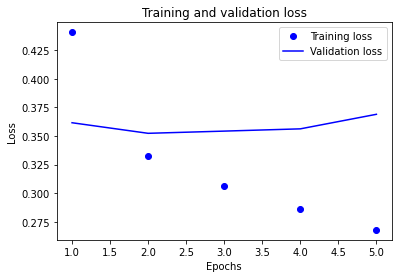

In [12]:
# 결과 확인
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 3. CNN 모델2

In [13]:
# 단어 사전의 크기 및 차원
vocab_size = len(word_to_index)
word_vector_dim = 100  

# CNN모델
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 과적합으로 에폭수 감소
epochs = 5 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4735 - accuracy: 0.7785 - val_loss: 0.3638 - val_accuracy: 0.8390
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3240 - accuracy: 0.8616 - val_loss: 0.3528 - val_accuracy: 0.8461
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.2784 - accuracy: 0.8846 - val_loss: 0.3542 - val_accuracy: 0.8483
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.2409 - accuracy: 0.9035 - val_loss: 0.3668 - val_accuracy: 0.8467
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.2038 - accuracy: 0.9221 - val_loss: 0.3901 - val_accuracy: 0.8440


In [15]:
# 테스트 값 결과 확인
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1284/1284 - 2s - loss: 0.4049 - accuracy: 0.8389
[0.40485355257987976, 0.838851809501648]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


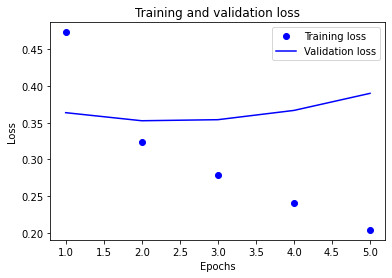

In [16]:
# 결과 확인
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 3. GRU 모델3

In [17]:
from transformers import *

In [18]:
# 단어 사전의 크기 및 차원
vocab_size = len(word_to_index)
word_vector_dim = 100  

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(12))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
gru (GRU)                    (None, 12)                4104      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 1,004,117
Trainable params: 1,004,117
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

epochs = 5 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
469/469 [==============================] - 4s 6ms/step - loss: 0.4216 - accuracy: 0.8091 - val_loss: 0.3600 - val_accuracy: 0.8400
Epoch 2/5
469/469 [==============================] - 3s 5ms/step - loss: 0.3403 - accuracy: 0.8526 - val_loss: 0.3461 - val_accuracy: 0.8486
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3201 - accuracy: 0.8624 - val_loss: 0.3361 - val_accuracy: 0.8524
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3022 - accuracy: 0.8711 - val_loss: 0.3262 - val_accuracy: 0.8578
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.2862 - accuracy: 0.8799 - val_loss: 0.3215 - val_accuracy: 0.8608


In [20]:
# 테스트 값 결과 확인
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1284/1284 - 2s - loss: 0.3312 - accuracy: 0.8584
[0.33121728897094727, 0.8584262728691101]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


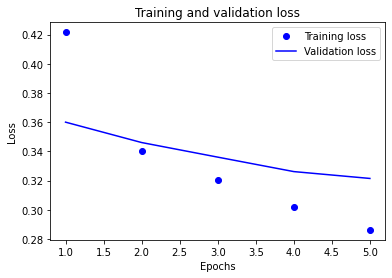

In [21]:
# 결과 확인
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 4. 한국어 word2vec임베딩을 활용

In [23]:
# word2ver를 이용하여 학습
from gensim.models import Word2Vec
from tensorflow.keras.initializers import Constant

# sg = 0은 CBOW, 1은 Skip-gram.
word2vec = Word2Vec(token_word_list, vector_size=100, window=2, min_count=5, workers=4, sg=1)
word2vec.wv.vectors.shape

(18119, 100)

In [26]:
# 임베딩 메트릭스 준비
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

index_to_word = {index:word for word, index in word_to_index.items()}

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [40]:
# 발리데이션 로스값이 잘 떨어졌던 GRU모델 준비
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_shape=(None,),
                                    trainable=True))
model.add(tf.keras.layers.GRU(12))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 12)                4104      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 13        
Total params: 1,004,117
Trainable params: 1,004,117
Non-trainable params: 0
_________________________________________________________________


In [41]:
# 모델 훈련
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

epochs = 15 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
469/469 [==============================] - 4s 6ms/step - loss: 0.4197 - accuracy: 0.8075 - val_loss: 0.3608 - val_accuracy: 0.8405
Epoch 2/15
469/469 [==============================] - 3s 5ms/step - loss: 0.3406 - accuracy: 0.8511 - val_loss: 0.3399 - val_accuracy: 0.8516
Epoch 3/15
469/469 [==============================] - 3s 5ms/step - loss: 0.3172 - accuracy: 0.8635 - val_loss: 0.3310 - val_accuracy: 0.8560
Epoch 4/15
469/469 [==============================] - 3s 6ms/step - loss: 0.3009 - accuracy: 0.8716 - val_loss: 0.3240 - val_accuracy: 0.8589
Epoch 5/15
469/469 [==============================] - 3s 5ms/step - loss: 0.2874 - accuracy: 0.8786 - val_loss: 0.3317 - val_accuracy: 0.8565
Epoch 6/15
469/469 [==============================] - 3s 5ms/step - loss: 0.2759 - accuracy: 0.8840 - val_loss: 0.3164 - val_accuracy: 0.8625
Epoch 7/15
469/469 [==============================] - 3s 6ms/step - loss: 0.2651 - accuracy: 0.8894 - val_loss: 0.3248 - val_accuracy: 0.8596
Epoch 

In [42]:
# 테스트 값 결과 확인
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1284/1284 - 2s - loss: 0.3509 - accuracy: 0.8567
[0.35085877776145935, 0.8566733002662659]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


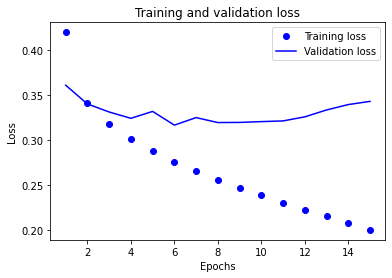

In [43]:
# 결과 확인
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### genims을 활용하여 학습된 임베딩과 word2vec 비교 분석

In [45]:
word2vec.wv.most_similar("정말")

[('정말로', 0.8532505035400391),
 ('진짜', 0.852863609790802),
 ('ㅠㅜ', 0.7582256197929382),
 ('진심', 0.7316354513168335),
 ('참', 0.7222082018852234),
 ('너무너무', 0.7178539037704468),
 ('ㅠㅠ너무', 0.7130423188209534),
 ('증말', 0.7126389145851135),
 ('진짜로', 0.7110286951065063),
 ('무튼', 0.7052884101867676)]

기존의 임베딩은 단순히 많이 사용된 단어순으로 인덱스 값이 매겨졌다면 word2ver는 위와 같이 확실하게 비슷한 언어들이 백터화 된것을 알 수 있다.   
따라서 독단적으로 학습이 완료된 말뭉치보다 긍부정에 관련된 말뭉치로 학습하면 더 좋은 결과가 있을 것으로 예상되었으나 생각보다 좋지 않았다.
결론적으로 정확도는 85%는 달성하였으나 모든 모델들이 엇비슷하였다